# What you should do here

* create the `models` directory containing the trained models
* if the folder is already there : not overwrite

Notebook with the code needed to train and store models to disk. This notebook has to be clean (**do not define functions here, do them in an external utils.py and import them**). The notebook has to be reproducible (if you run it twice, the same output has to be displayed and stored to disk).


The train_models.ipynb notebook:

* Is a responsability of all members of a group. All of you should execute this and ensure it works as expected.
* Has to use the code done by each member in the group to generate features for the challenge

# Read the data
At first we read the data.

In [1]:
import pandas as pd
import scipy
import sklearn
from sklearn import *
import numpy as np
import os
import nltk

from utils import *

[nltk_data] Downloading package wordnet to /Users/max/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/max/My Drive/_Universität_HPI/Semester 6/NLP/Assignment 1/barcelona_nlp/assign3max/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
home_dir = os.environ['HOME']
path_folder_quora = home_dir + '/Datasets/QuoraQuestionPairs'

train_df = pd.read_csv(os.path.join(path_folder_quora, 'quora_train_data.csv'))
test_df = pd.read_csv(os.path.join(path_folder_quora, 'quora_test_data.csv'))
train_df = train_df.dropna()


In [3]:
# we work with that
A_df, te_df = sklearn.model_selection.train_test_split(train_df, test_size=0.05,random_state=123)

# can be ignored
tr_df, va_df = sklearn.model_selection.train_test_split(A_df, test_size=0.05,random_state=123)
print('tr_df.shape=',tr_df.shape)
print('va_df.shape=',va_df.shape)
print('te_df.shape=',te_df.shape)


# Trainings- und Testdatenvariablen
q1_train = cast_list_as_strings(list(tr_df["question1"]))
q2_train = cast_list_as_strings(list(tr_df["question2"]))
q1_val = cast_list_as_strings(list(va_df["question1"]))
q2_val = cast_list_as_strings(list(va_df["question2"]))
q1_test = cast_list_as_strings(list(te_df["question1"]))
q2_test = cast_list_as_strings(list(te_df["question2"]))
labels_train = tr_df["is_duplicate"]
labels_val = va_df["is_duplicate"]
labels_test = te_df["is_duplicate"]


tr_df.shape= (291894, 6)
va_df.shape= (15363, 6)
te_df.shape= (16172, 6)


# Baseline model

In [4]:
all_questions = q1_train + q2_train
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,1))
count_vectorizer.fit(all_questions)

CountVectorizer()

In [5]:
X_tr_q1q2 = get_features_from_df(tr_df, count_vectorizer)
X_te_q1q2  = get_features_from_df(te_df, count_vectorizer)
X_val_q1q2  = get_features_from_df(va_df, count_vectorizer)

In [6]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear",
                                                   random_state=123)
y_train = tr_df["is_duplicate"].values
logistic.fit(X_tr_q1q2, y_train)

LogisticRegression(random_state=123, solver='liblinear')

In [7]:
import pickle
import os

if not os.path.isdir("models"):
    os.mkdir("models")

if not os.path.isdir("models/simple_solution"):
    os.mkdir("models/simple_solution")
    # Save model and validation and test datasets

    with open('models/simple_solution/baseline.pkl', 'wb') as file:
        pickle.dump(logistic, file)

    with open('models/simple_solution/X_tr_q1q2.pkl', 'wb') as file:
            pickle.dump(X_tr_q1q2, file)
    with open('models/simple_solution/labels_train.pkl', 'wb') as file:
        pickle.dump(labels_train, file)

    with open('models/simple_solution/X_val_q1q2.pkl', 'wb') as file:
            pickle.dump(X_val_q1q2, file)
    with open('models/simple_solution/labels_val.pkl', 'wb') as file:
        pickle.dump(labels_val, file)

    with open('models/simple_solution/X_te_q1q2.pkl', 'wb') as file:
            pickle.dump(X_te_q1q2, file)
    with open('models/simple_solution/labels_test.pkl', 'wb') as file:
        pickle.dump(labels_test, file)



In [8]:
from sklearn.metrics import classification_report

Test_q1 = count_vectorizer.transform(q1_test)
Test_q2 = count_vectorizer.transform(q2_test)    
Test_q1q2 = scipy.sparse.hstack((Test_q1,Test_q2))

test_predictions = logistic.predict(Test_q1q2)

# Performance evaluation
print("Test Report:")
print(classification_report(labels_test, test_predictions))


Test Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81     10178
           1       0.69      0.61      0.65      5994

    accuracy                           0.75     16172
   macro avg       0.74      0.72      0.73     16172
weighted avg       0.75      0.75      0.75     16172



# Complex Model

## Feature Model


In [9]:
tr_df = complex_preprocess(tr_df)
va_df = complex_preprocess(va_df)
te_df = complex_preprocess(te_df)

  0%|          | 0/291894 [00:00<?, ?it/s]

100%|██████████| 16172/16172 [00:01<00:00, 13834.10it/s]


In [10]:
fE = Feature_Extractor(tr_df, va_df, te_df)
hand_features= get_hand_features()
tr_df[hand_features], va_df[hand_features], te_df[hand_features] = fE.all_feature_extraction()

100%|██████████| 16172/16172 [01:48<00:00, 149.58it/s]


In [36]:
import pickle
if not os.path.isdir("models/complex_model"):
    os.mkdir("models/complex_model")
    # Save model and validation and test datasets
with open('models/complex_model/tr_df', 'wb') as file:
    pickle.dump(tr_df, file)
    
with open('models/complex_model/va_df', 'wb') as file:
    pickle.dump(va_df, file)
with open('models/complex_model/te_df', 'wb') as file:
    pickle.dump(te_df, file)


In [25]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

tr_df_copy = tr_df.copy()
va_df_copy = va_df.copy()
te_df_copy = te_df.copy()

scaler = StandardScaler()
tr_df_copy[hand_features] = scaler.fit_transform(tr_df_copy[hand_features])
va_df_copy[hand_features] = scaler.transform(va_df_copy[hand_features])
te_df_copy[hand_features] = scaler.transform(te_df_copy[hand_features])

dTrain1 = xgb.DMatrix(tr_df_copy[hand_features], label=tr_df_copy['is_duplicate'])
dVal1 = xgb.DMatrix(va_df_copy[hand_features], label=va_df_copy['is_duplicate'])
xgb_params1 = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1, 
    'max_depth': 12,
    'subsample': 0.9,
    'colsample_bytree': 1 / 15**0.5,
    'min_child_weight': 5,
    'silent': 1
}


bst1 = xgb.train(xgb_params1, dTrain1, 1000,  [(dTrain1,'train'), (dVal1,'val')], 
                verbose_eval=10, early_stopping_rounds=30)
with open('models/complex_model/bst1', 'wb') as file:
        pickle.dump(bst1, file)

[0]	train-logloss:0.63803	train-error:0.36878	val-logloss:0.63753	val-error:0.36679


/Users/max/My Drive/_Universität_HPI/Semester 6/NLP/Assignment 1/barcelona_nlp/assign3max/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/max/My Drive/_Universität_HPI/Semester 6/NLP/Assignment 1/barcelona_nlp/assign3max/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:34:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-logloss:0.53130	train-error:0.28109	val-logloss:0.53556	val-error:0.29018
[20]	train-logloss:0.48854	train-error:0.24943	val-logloss:0.49744	val-error:0.26056
[30]	train-logloss:0.46847	train-error:0.24333	val-logloss:0.48085	val-error:0.25750
[40]	train-logloss:0.45108	train-error:0.23091	val-logloss:0.46938	val-error:0.25282
[50]	train-logloss:0.44260	train-error:0.22502	val-logloss:0.46540	val-error:0.24897
[60]	train-logloss:0.43329	train-error:0.21975	val-logloss:0.45950	val-error:0.24539
[70]	train-logloss:0.42461	train-error:0.21290	val-logloss:0.45548	val-error:0.24390
[80]	train-logloss:0.41895	train-error:0.20915	val-logloss:0.45339	val-error:0.24572
[90]	train-logloss:0.41296	train-error:0.20361	val-logloss:0.45142	val-error:0.24455
[100]	train-logloss:0.40822	train-error:0.19992	val-logloss:0.44999	val-error:0.24390
[110]	train-logloss:0.40205	train-error:0.19482	val-logloss:0.44820	val-error:0.24312
[120]	train-logloss:0.39789	train-error:0.19124	val-logloss:0.4

In [37]:
with open('models/complex_model/tr_df_copy', 'wb') as file:
    pickle.dump(tr_df_copy, file)
with open('models/complex_model/va_df_copy', 'wb') as file:
    pickle.dump(va_df_copy, file)
with open('models/complex_model/te_df_copy', 'wb') as file:
    pickle.dump(te_df_copy, file)

Accuracy: 0.7600173138758348
ROC AUC: 0.8470884505387026
Precision: 0.6686891266166374
Recall: 0.6986986986986987
F1 Score: 0.683364607979114
Log Loss: 0.44746957324285713


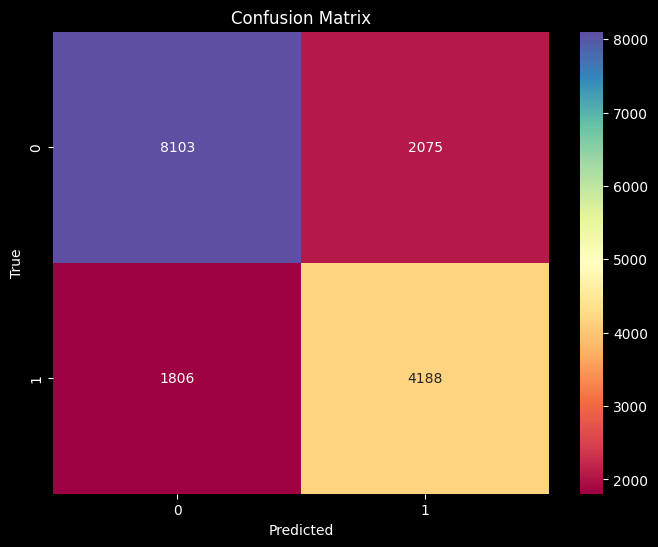

In [35]:
evaluate_boost(bst1, te_df_copy[hand_features], te_df_copy['is_duplicate'])

## Extended Embeddings Model

In [28]:
tr_df
eC = Embedding_Calculator(tr_df, va_df, te_df)
F_train_all_norm, F_val_all_norm, F_test_all_norm, y_train, y_val, y_test = eC.get_embeddings()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 100)   │  1,000,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    365,568 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256)       │          0 │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         17 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,369,697 (5.22 MB)

 Trainable params: 1,369,697 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 384s 168ms/step - loss: 0.5384 - val_loss: 0.4654
Epoch 2/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 414s 182ms/step - loss: 0.4315 - val_loss: 0.4243
Epoch 3/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 407s 178ms/step - loss: 0.3765 - val_loss: 0.4062
Epoch 4/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 469s 205ms/step - loss: 0.3313 - val_loss: 0.4005
Epoch 5/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 475s 208ms/step - loss: 0.2894 - val_loss: 0.3983
Epoch 6/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 469s 206ms/step - loss: 0.2526 - val_loss: 0.4104
Epoch 7/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 459s 201ms/step - loss: 0.2130 - val_loss: 0.4210
Epoch 8/10
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 444s 195ms/step - loss: 0.1806 - val_loss: 0.4547
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 165s 72ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step


In [33]:
if not os.path.isdir("models/complex_model"):
    os.mkdir("models/complex_model")
    # Save model and validation and test datasets
with open('models/complex_model/F_train_all_norm', 'wb') as file:
    pickle.dump(F_train_all_norm, file)

with open('models/complex_model/F_val_all_norm', 'wb') as file:
    pickle.dump(F_val_all_norm , file)

with open('models/complex_model/F_test_all_norm', 'wb') as file:
    pickle.dump(F_test_all_norm, file)

with open('models/complex_model/y_train', 'wb') as file:
    pickle.dump(y_train, file)

with open('models/complex_model/y_val', 'wb') as file:
    pickle.dump(y_val, file)

with open('models/complex_model/y_test', 'wb') as file:
    pickle.dump(y_test, file)

In [31]:
import xgboost as xgb
dTrain = xgb.DMatrix(F_train_all_norm, label=y_train)
dVal = xgb.DMatrix(F_val_all_norm, label=y_val)
xgb_params2 = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1, 
    'max_depth': 12,
    'subsample': 0.9,
    'colsample_bytree': 1 / 270**0.5,#F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}


finalmodel = xgb.train(xgb_params2, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')], 
                verbose_eval=10, early_stopping_rounds=30)

with open('models/complex_model/finalmodel', 'wb') as file:
        pickle.dump(finalmodel, file)

/Users/max/My Drive/_Universität_HPI/Semester 6/NLP/Assignment 1/barcelona_nlp/assign3max/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/max/My Drive/_Universität_HPI/Semester 6/NLP/Assignment 1/barcelona_nlp/assign3max/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:39:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.61604	train-error:0.36878	val-logloss:0.62069	val-error:0.36679
[10]	train-logloss:0.39781	train-error:0.13403	val-logloss:0.44663	val-error:0.18870
[20]	train-logloss:0.31411	train-error:0.10736	val-logloss:0.39475	val-error:0.17458
[30]	train-logloss:0.26559	train-error:0.09119	val-logloss:0.37283	val-error:0.16885
[40]	train-logloss:0.23235	train-error:0.07843	val-logloss:0.36300	val-error:0.16605
[50]	train-logloss:0.20948	train-error:0.06881	val-logloss:0.35773	val-error:0.16436
[60]	train-logloss:0.19075	train-error:0.06037	val-logloss:0.35800	val-error:0.16312
[70]	train-logloss:0.17717	train-error:0.05447	val-logloss:0.35874	val-error:0.16266
[80]	train-logloss:0.16478	train-error:0.04854	val-logloss:0.35692	val-error:0.16175
[90]	train-logloss:0.15238	train-error:0.04239	val-logloss:0.35549	val-error:0.15791
[100]	train-logloss:0.14355	train-error:0.03805	val-logloss:0.35629	val-error:0.15778
[110]	train-logloss:0.13476	train-error:0.03378	val-logloss:0.355

Accuracy: 0.8417635419243136
ROC AUC: 0.9192451769251403
Precision: 0.7908552074513124
Recall: 0.7791124457791124
F1 Score: 0.7849399109168838
Log Loss: 0.3777052047799151


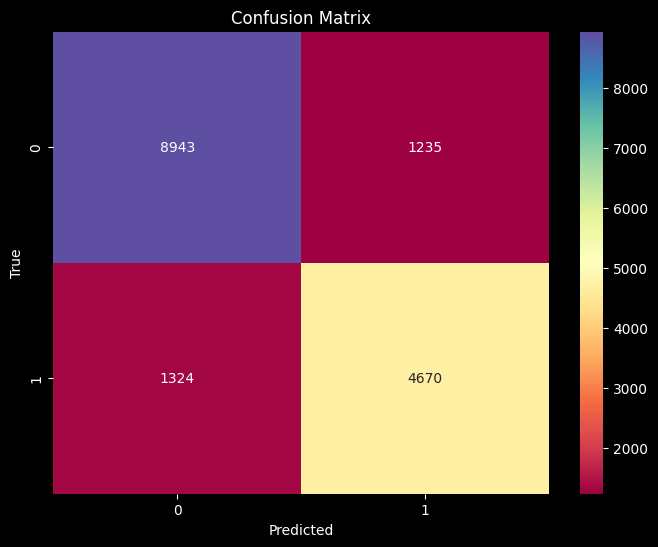

In [32]:
evaluate_boost(finalmodel, F_test_all_norm, y_test)